In [3]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
from glob import glob
import json, codecs
from keras.models import load_model

# Transfer Learning'in Amacı Nedir?
- TL'nin amacı, daha önce oluşturulmuş, öğrenilmiş, transfer edilmiş weight değerleri eğitilmiş bir modeli kullanarak, yalnızca outputunu ya da full connected layerını train ederek, import edilerek yapılan bir yöntemdir.

## 1-Read Data

In [4]:
train_path = "data/Training/"
test_path = "data/Test/"

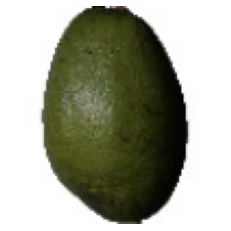

In [5]:
img = load_img(train_path + "Avocado/0_100.jpg")
plt.imshow(img)
plt.axis("off")
plt.show()

In [4]:
x = img_to_array(img) # jpg to array
x.shape # 100x100 and 3=RGB

(100, 100, 3)

In [5]:
numberOfClass = len(glob(train_path+"/*"))
numberOfClass # There are 131 kinds of fruits (class)

131

## 2-Create VGG16 Model

- This model consists of 16 layers.

In [6]:
vgg = VGG16()

In [7]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
vgg_layer_list = vgg.layers
vgg_layer_list

In [9]:
len(vgg_layer_list)

23

### NOTE
- Yukarıdaki çıktıya göre, VGG 16 Layerdan oluştuğu söylendiği halde  yukarıda 23 layer var. Bunlar arasında, 1 adet input, 5 adet Pooling layerlar ve 1 adet Flatten bunlar dahil değildir.

### NOTE
- Aşağıdaki son indexte, dense output layerı bulunmaktadır ve içerisinde yukarıda summary() fonksiyonu ile yararlanarak 1000 tane class oluşturmaktadır.
- Bizim datasetimizde 131 tane meyve olduğu için vgg içerisindeki output layer hariç tüm aşağıdaki gibi layerları bir model içerisine ekleyeceğiz. 

In [10]:
vgg_layer_list[-1]

In [11]:
model = Sequential()
for i in range(len(vgg_layer_list)-1):
    model.add(vgg_layer_list[i])

In [12]:
model.summary() # output dense(predict) artık yok.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

### NOTE
- Aşağıda modelin her bir layerı dolaşılır.
- Her bir layer dolaşılırken **train edilmesin** özelliği seçilir.
- Daha önceden **ImageNet** datası kullanılarak train edilmiş weightler kullanılacak.
- Yalnızca en son eklenecek layerın weightleri train edilecek.

In [13]:
for layers in model.layers:
    layers.trainable = False

In [14]:
# numberOfClass=units=nerons
model.add(Dense(numberOfClass, activation="softmax")) # softmax for multiclass
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

### Compile Model

In [15]:
model.compile(loss = "categorical_crossentropy",
              optimizer = "rmsprop",
              metrics = ["accuracy"])

## 3-Train Data

### NOTE
- ImageNet üzerinde resim boyutu 224x224 olduğunda belirtilen path içerisindeki tüm train ve test resimlerinin boyutu 224x224 yapıldı.

In [16]:
train_data = ImageDataGenerator().flow_from_directory(train_path, target_size = (224,224))
test_data = ImageDataGenerator().flow_from_directory(test_path, target_size = (224,224))
batch_size = 32

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [17]:
hist = model.fit(train_data,
                           steps_per_epoch = 1600 // batch_size, # yaklaşık 50 steps.
                           epochs = 25,
                           validation_data = test_data,
                           validation_steps = 800 // batch_size) # yaklaşık 25 steps

Epoch 1/25
50/50 [==============================] - 450s 9s/step - loss: 3.7531 - accuracy: 0.4238 - val_loss: 1.9484 - val_accuracy: 0.6062
Epoch 2/25
50/50 [==============================] - 449s 9s/step - loss: 0.9350 - accuracy: 0.7600 - val_loss: 1.2161 - val_accuracy: 0.7337
Epoch 3/25
50/50 [==============================] - 454s 9s/step - loss: 0.4842 - accuracy: 0.8569 - val_loss: 1.0059 - val_accuracy: 0.8138
Epoch 4/25
50/50 [==============================] - 446s 9s/step - loss: 0.3089 - accuracy: 0.9069 - val_loss: 0.6926 - val_accuracy: 0.8487
Epoch 5/25
50/50 [==============================] - 446s 9s/step - loss: 0.2358 - accuracy: 0.9275 - val_loss: 0.7490 - val_accuracy: 0.8300
Epoch 6/25
50/50 [==============================] - 445s 9s/step - loss: 0.1488 - accuracy: 0.9563 - val_loss: 0.8969 - val_accuracy: 0.8300
Epoch 7/25
50/50 [==============================] - 447s 9s/step - loss: 0.1807 - accuracy: 0.9531 - val_loss: 0.8886 - val_accuracy: 0.8275
Epoch 8/25
50

## 4-Save Model and History

In [18]:
model.save("vgg16_demo.h5")
with open("vgg16_demo.json","w") as f:
    json.dump(hist.history, f)

## 5-Load Model and History

In [6]:
with codecs.open("vgg16_demo.json", "r", encoding = "utf-8") as f:
    history1 = json.loads(f.read())
model1 = load_model("vgg16_demo.h5")

In [7]:
history1.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## 6-Evaluation Model

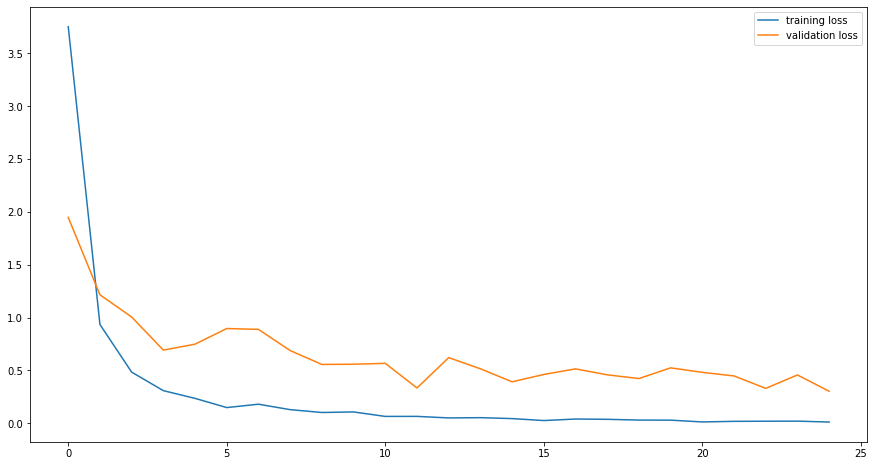

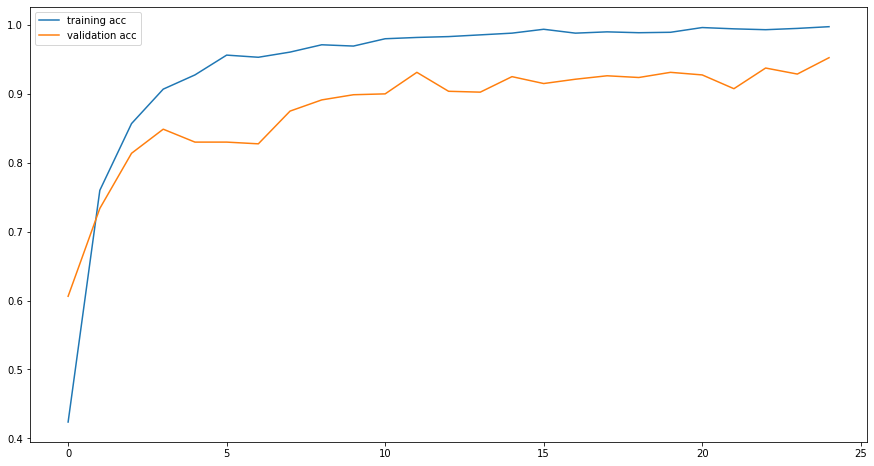

In [8]:
plt.figure(figsize = (15, 8))
plt.plot(history1["loss"], label = "training loss")
plt.plot(history1["val_loss"], label = "validation loss")
plt.legend()
plt.show()
plt.figure(figsize = (15, 8))
plt.plot(history1["accuracy"], label = "training acc")
plt.plot(history1["val_accuracy"], label = "validation acc")
plt.legend()
plt.show()